In [1]:
# FOR GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive')
!pip install xgboost
!pip install catboost
!pip install lightgbm

Mounted at /content/drive
     |████████████████████████████████| 65.8MB 59kB/s 


In [65]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

In [3]:
# numerical data processing
def _transfrom_basic(df ):
    df['is_fresher'] = df['previous_year_rating'].apply(lambda x: 1 if x ==0 else 0 )
    df['age_2'] = pd.cut( x=df['age'], bins=[20, 29, 39, 49], labels=['0', '1', '2'] )
    return df


class AddStatisticFt(BaseEstimator, TransformerMixin):
    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        inp = X.copy()
        pro1 = np.expand_dims( np.mean(inp, axis = 1) , -1)
        pro2 = np.expand_dims( np.std(inp, axis = 1) , -1)
        pro3 = np.expand_dims( np.median(inp, axis = 1) , -1)
        pro4 = np.expand_dims( np.var(inp, axis = 1) , -1)
        return np.concatenate([inp, pro1, pro2, pro3, pro4], axis= 1) 


# Multicolumn Label encoder
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode
        self.dict_encoder = {}

    def fit(self,X,y=None):
        for i in self.columns:
            encoder = preprocessing.LabelEncoder()
            encoder.fit(X[i].astype(str))
            self.dict_encoder[i] = encoder
        return self # not relevant here

    def transform(self,X):
        output = X[self.columns].copy()
        for i in self.columns:
            output[i] = self.dict_encoder[i].transform(output[i])
        return output

def evaluate_model(model, X, y):
    try:
        y_pred = model.predict_proba(X)[:, 1]
    except:
        y_pred = model.predict(X)

    fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y, y_pred)
    auc_s = auc(fpr_rt_lm, tpr_rt_lm)
    print('AUC: ', auc_s)
    print('Gini: ', 2*auc_s - 1)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [4]:
folder_path = '/content/drive/MyDrive/Data/colabs_data/HR_pred'
train_path = folder_path + '/train_LZdllcl.csv'
test_path = folder_path +  '/test_2umaH9m.csv'

In [5]:
# Data loading
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [6]:
# cols classifying
cols_id = ['employee_id']
col_label = 'is_promoted'
cols_ft = [col for col in df_train.columns if col not in cols_id + [col_label] ]
cols_ft_cat = [col for col in df_train.columns if col not in cols_id + [col_label] and df_train[col].dtype=='object']
cols_ft_num = [col for col in cols_ft if col not in cols_ft_cat] 

In [7]:
# for i in cols_ft_cat:
#     print( df_train.groupby(i)['employee_id'].count().sort_values(ascending = False) )
# # => dữ liệu khá sạch

In [8]:
cols_ft += ['is_fresher', 'age_2']
cols_ft_cat += ['age_2']
cols_ft_num += ['is_fresher']

df_train = _transfrom_basic(df_train)
df_test = _transfrom_basic(df_test)

In [9]:
X_train, X_test, y_train, y_test = train_test_split( df_train[cols_ft], df_train[col_label], test_size=0.33, random_state=42)

0:	learn: 0.5622865	total: 13.1ms	remaining: 6.43s
1:	learn: 0.5020338	total: 25.7ms	remaining: 6.32s
2:	learn: 0.4520390	total: 38.7ms	remaining: 6.33s
3:	learn: 0.4267094	total: 51ms	remaining: 6.25s
4:	learn: 0.4122328	total: 63.3ms	remaining: 6.19s
5:	learn: 0.3965361	total: 84.6ms	remaining: 6.88s
6:	learn: 0.3831944	total: 97.5ms	remaining: 6.78s
7:	learn: 0.3661972	total: 110ms	remaining: 6.67s
8:	learn: 0.3545049	total: 122ms	remaining: 6.58s
9:	learn: 0.3383924	total: 135ms	remaining: 6.53s
10:	learn: 0.3350920	total: 148ms	remaining: 6.48s
11:	learn: 0.3335985	total: 160ms	remaining: 6.41s
12:	learn: 0.3305572	total: 172ms	remaining: 6.35s
13:	learn: 0.3201259	total: 184ms	remaining: 6.29s
14:	learn: 0.3149185	total: 195ms	remaining: 6.24s
15:	learn: 0.3091790	total: 207ms	remaining: 6.2s
16:	learn: 0.3034948	total: 224ms	remaining: 6.29s
17:	learn: 0.3025694	total: 236ms	remaining: 6.25s
18:	learn: 0.3012613	total: 249ms	remaining: 6.21s
19:	learn: 0.3007175	total: 261ms	rem

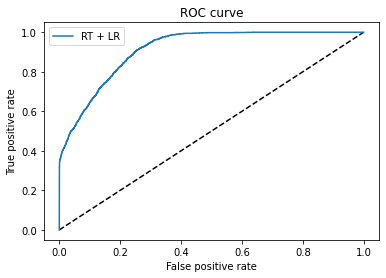

Train AUC
AUC:  0.9657842708441287
Gini:  0.9315685416882573


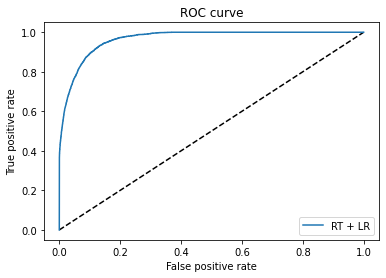

In [110]:
# Model compile
list_estimators = [
    ('rf', ensemble.RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5)),
    ('xtree', ensemble.ExtraTreesClassifier(max_depth=5)),
    ('gbt', ensemble.GradientBoostingClassifier(max_depth=5)),
    ('ada', ensemble.AdaBoostClassifier())
]
stacked_model = ensemble.StackingClassifier(
    estimators=list_estimators, final_estimator=LogisticRegression(), 
    cv = 10, n_jobs = -1
)

estimators = [
    (
        'xgb', XGBClassifier(learning_rate =0.1, n_estimators=494, max_depth=5, subsample = 0.70, verbosity = 0,
              scale_pos_weight = 2.5, updater ="grow_histmaker", base_score  = 0.2)
    ),
    (
        'catboost', CatBoostClassifier(learning_rate=0.15, n_estimators=494, subsample=0.085, max_depth=5, scale_pos_weight=2.5)
    ),
    (
        'lightgbm', LGBMClassifier(subsample_freq = 2,  objective ="binary",  importance_type = "gain",  verbosity = -1,   max_bin = 60,  
                              num_leaves = 300,  boosting_type = 'dart',  learning_rate=0.15,   n_estimators=494,  
                              max_depth=5,   scale_pos_weight=2.5)
    ),
    ( 'stacked', stacked_model )
]

clf = ensemble.VotingClassifier(estimators= estimators, voting='soft',weights=[5,5,5.2,5])
# ensemble.StackingClassifier(
#     estimators=estimators, final_estimator=LogisticRegression(), 
#     cv = 10, n_jobs = -1
# )

p_cat = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) ,
    ('encode', preprocessing.OneHotEncoder()) #  MultiColumnLabelEncoder(columns = cols_ft_cat )
])
p_num = Pipeline([
    ('fillna', SimpleImputer(strategy='constant', fill_value=0)),
    ('norm', preprocessing.RobustScaler()),
    # ('add_stats',AddStatisticFt())
])
p1 = ColumnTransformer([
    ('cat', p_cat, cols_ft_cat ),
    ('num', p_num, cols_ft_num)
])

pipe = Pipeline([
    ('transformer', p1),
    ('predictor', clf)
])

#### Fitting
# pipe.fit(df_train[cols_ft], df_train[col_label])

# p1.fit(pd.concat([df_train[cols_ft], df_test[cols_ft]]))

# pipe = clf
# pipe.fit( X, y)

pipe.fit(X_train, y_train)

# Evaluating
print('Test AUC')
evaluate_model(pipe, X_test[cols_ft], y_test)

print('Train AUC')
evaluate_model(pipe, X_train[cols_ft], y_train)


In [112]:
f1_score(y_test, pipe.predict(X_test))

0.5266485998193315

In [113]:
def _f1_at_threshold( y_true, y_pred_prob, threshold):
  y_pred = np.apply_along_axis(lambda x: 1 if x >= threshold else 0 , 1, np.expand_dims(y_pred_prob, -1) )
  print( 'F1 at :', threshold, ' is: ', f1_score( y_true, y_pred) )

In [116]:
y_pred_prb = pipe.predict_proba(X_test)[:,1]
for i in range(0,50,1):
  threshold= i/50
  _f1_at_threshold(y_test, y_pred_prb,threshold)

F1 at : 0.0  is:  0.1507080415111702
F1 at : 0.02  is:  0.27719596188319656
F1 at : 0.04  is:  0.304
F1 at : 0.06  is:  0.3239562402321947
F1 at : 0.08  is:  0.3388625592417062
F1 at : 0.1  is:  0.35248369292523835
F1 at : 0.12  is:  0.3665370693122403
F1 at : 0.14  is:  0.3822937625754527
F1 at : 0.16  is:  0.39524103831891216
F1 at : 0.18  is:  0.40691043274069105
F1 at : 0.2  is:  0.4174986385913959
F1 at : 0.22  is:  0.43424955507217716
F1 at : 0.24  is:  0.447294066507281
F1 at : 0.26  is:  0.4596507786691836
F1 at : 0.28  is:  0.46811779769526246
F1 at : 0.3  is:  0.48320268756998885
F1 at : 0.32  is:  0.49181322013341416
F1 at : 0.34  is:  0.5
F1 at : 0.36  is:  0.5117565698478562
F1 at : 0.38  is:  0.5201760821716801
F1 at : 0.4  is:  0.517121969988457
F1 at : 0.42  is:  0.517741935483871
F1 at : 0.44  is:  0.5203183912861332
F1 at : 0.46  is:  0.5226390685640362
F1 at : 0.48  is:  0.5265486725663717
F1 at : 0.5  is:  0.5266485998193315
F1 at : 0.52  is:  0.5252989880404784
F1 

In [115]:
# df_test['is_promoted'] = pipe.predict( p1.transform( df_test[cols_ft]) )
df_test['is_promoted'] = pipe.predict( df_test[cols_ft])
df_test['is_promoted_prob'] = pipe.predict_proba(df_test[cols_ft])[:,1]

# df_test[['employee_id', 'is_promoted']].to_csv( folder_path + '/submission.csv', index = False)
df_test[['employee_id', 'is_promoted']].to_csv( 'submission.csv', index = False)
